In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.feature_selection import mutual_info_regression as MIR

In [2]:
format_plots()
#format_pizza_plots()

In [3]:
## update data
def filter_df(df):
    max=39
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [4]:
# arrange data
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_males_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()
data['data'] = 'min'
data.set_index('data', inplace=True, append=True)

data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid']).mean()
data_dana['data'] = 'dana'
data_dana.set_index('data', inplace=True, append=True)

data_all = pd.concat([data,data_dana])
# choose 16 mice from all dataset
random_seed = 0
n=16
data_all = data_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False,random_state=random_seed) if len(x)>n else x.sample(n=len(x),replace=False,random_state=random_seed)).reset_index(level=0, drop=True)
data_all = data_all[sorted(data_all.columns)]
m_data = data_all.query('age<100')

In [5]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_females_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

# arrange data
data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()
data['data'] = 'min'
data.set_index('data', inplace=True, append=True)

data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid']).mean()
data_dana['data'] = 'dana'
data_dana.set_index('data', inplace=True, append=True)

data_all = pd.concat([data,data_dana])
# choose 16 mice from all dataset
random_seed = 0
n=16
data_all = data_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False,random_state=random_seed) if len(x)>n else x.sample(n=len(x),replace=False,random_state=random_seed)).reset_index(level=0, drop=True)
data_all = data_all[sorted(data_all.columns)]
f_data = data_all.query('age<100')

In [6]:
# use only common ages
f_ages = f_data.index.get_level_values('age').unique().to_numpy()
m_ages = m_data.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))
m_data = m_data.loc[m_data.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = f_data.loc[f_data.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

In [7]:
## MI for age in ontogeny

In [8]:
X = m_data.to_numpy()
y = list(m_data.index.get_level_values('age'))
mi_score_m = MIR(X,y)

In [9]:
m_indx = np.argsort(mi_score_m)[::-1][0:40] # syllble index
impsyl_m= list(m_data.columns[m_indx]) #syllable id

In [10]:
print('10 most informative syllables for male: ',sorted(impsyl_m))

10 most informative syllables for male:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


In [11]:
## MI for age in longtogeny

In [12]:
X = f_data.to_numpy()
y = list(f_data.index.get_level_values('age'))
mi_score_f = MIR(X,y)

In [13]:
f_indx = np.argsort(mi_score_f)[::-1][0:40] # syllble index
impsyl_f= list(f_data.columns[f_indx]) #syllable id

In [14]:
print('10 most informative syllables for ontogeny: ',len(sorted(impsyl_f)))

10 most informative syllables for ontogeny:  40


In [15]:
mi_df = pd.DataFrame()
mi_df['mi'] = np.concatenate((mi_score_m,mi_score_f))
mi_df['syll'] = np.concatenate((np.array(m_data.columns),np.array(f_data.columns)))
#mi_df['rank']  = np.concatenate((np.array(impsyl_ont),np.array(impsyl_long)))
mi_df['exp'] = ['m']*len(m_data.columns)+['f']*len(f_data.columns)

In [16]:
mi_df['rank'] = mi_df.groupby('exp')['mi'].rank()

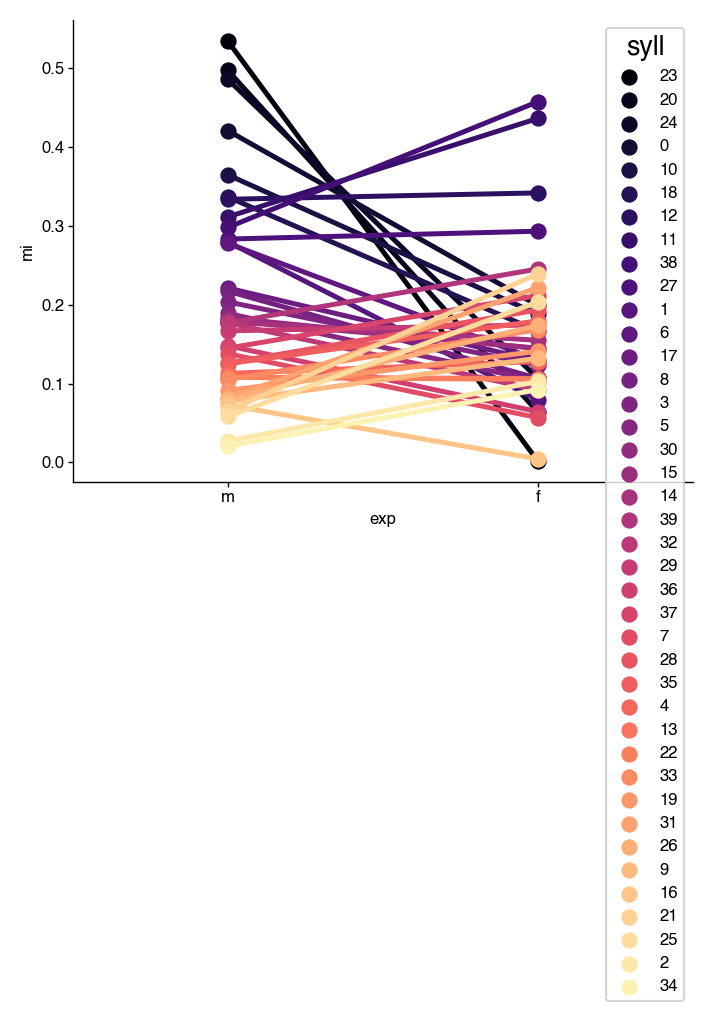

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3)

sns.pointplot(data=mi_df,x='exp',y='mi',hue='syll',join=True,palette='magma',hue_order=impsyl_m)

sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'fvm_syll_MI_aging.pdf')

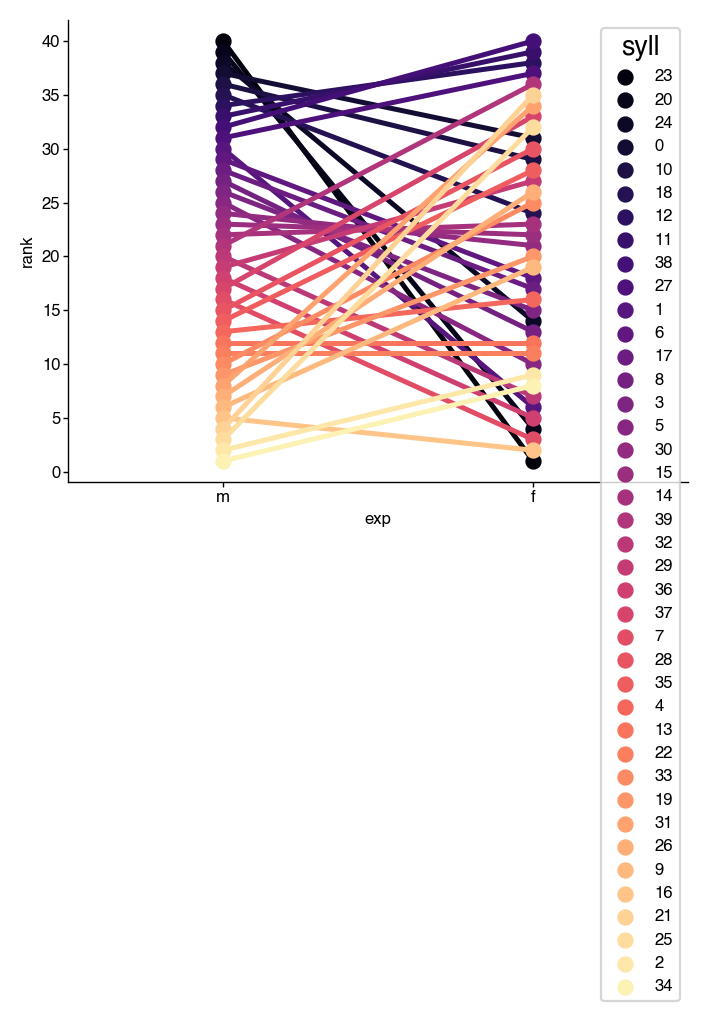

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3)

sns.pointplot(data=mi_df,x='exp',y='rank',hue='syll',join=True,palette='magma',hue_order=impsyl_m)

sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'fvm_syll_MI_aging_rank.pdf')